<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   futime    26 non-null     int64  
 1   fustat    26 non-null     int64  
 2   age       26 non-null     float64
 3   resid.ds  26 non-null     int64  
 4   rx        26 non-null     int64  
 5   ecog.ps   26 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 1.3 KB
None
            futime     fustat        age   resid.ds         rx    ecog.ps
count    26.000000  26.000000  26.000000  26.000000  26.000000  26.000000
mean    599.538462   0.461538  56.165442   1.576923   1.500000   1.461538
std     339.688473   0.508391  10.100361   0.503831   0.509902   0.508391
min      59.000000   0.000000  38.893200   1.000000   1.000000   1.000000
25%     368.000000   0.000000  50.167125   1.000000   1.000000   1.000000
50%     476.000000   0.000000  56.846600   2.000000   1.500000   1.000000
75%     794.7

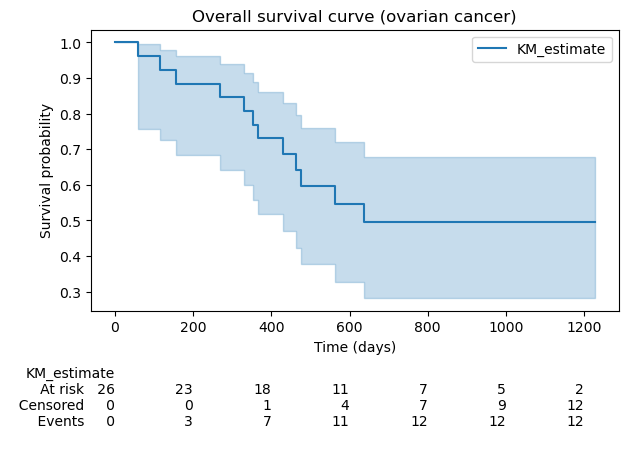

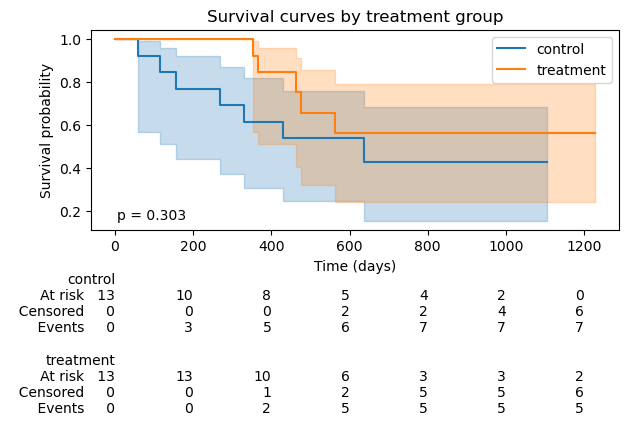

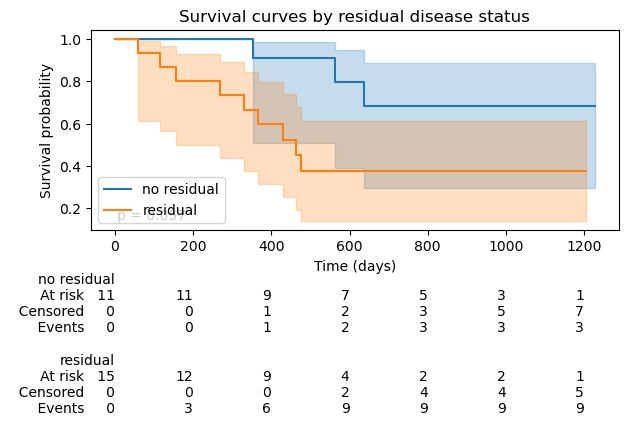

<lifelines.CoxPHFitter: fitted with 26 total observations, 14 right-censored observations>
             duration col = 'futime'
                event col = 'fustat'
      baseline estimation = breslow
   number of observations = 26
number of events observed = 12
   partial log-likelihood = -26.60
         time fit was run = 2025-12-01 17:25:16 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
age                    0.13      1.14      0.05            0.04            0.22                1.04                1.25
rx_factor_treatment   -0.85      0.43      0.64           -2.10            0.40                0.12                1.50
resid_factor_residual  0.70      2.01      0.76           -0.79            2.18                0.45                8.87

                       cmp to     z    p  -log2(p)
covariate                                         
age                      0.00  2.72 0.01      7.25
rx_factor_treatment      0.00 -1.33 0.18      2.44
resid_factor_residual    0.00  0.92 0.36      1.48
---
Concordance = 0.81
Partial AIC = 59.20
log-likelihood ratio test = 16.77 on 3 df
-log2(p) of ll-ratio test = 10.31

                       test_statistic         p  -log2(p)
age                          0.002380  0.961092  0.057254
resid_factor_residual        0.715338  0.397678  1.330329
rx_factor_treatment          0.593763  0.440968  1.181255


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.plotting import add_at_risk_counts

ovarian = pd.read_csv(r"C:\Users\click\Desktop\ovarian.csv")

print(ovarian.info())
print(ovarian.describe())

ovarian["rx_factor"] = ovarian["rx"].map({1: "control", 2: "treatment"})
ovarian["resid_factor"] = ovarian["resid.ds"].map({1: "no_residual", 2: "residual"})

s_obj = np.vstack([ovarian["futime"].values, (ovarian["fustat"] == 1).astype(int).values]).T
print(s_obj[:6])

kmf_all = KaplanMeierFitter()
kmf_all.fit(durations=ovarian["futime"], event_observed=(ovarian["fustat"] == 1).astype(int))
print(kmf_all.survival_function_)

fig, ax = plt.subplots()
kmf_all.plot_survival_function(ax=ax)
ax.set_title("Overall survival curve (ovarian cancer)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
add_at_risk_counts(kmf_all, ax=ax)
plt.tight_layout()
plt.show()

kmf_control = KaplanMeierFitter()
kmf_treatment = KaplanMeierFitter()

mask_control = ovarian["rx_factor"] == "control"
mask_treat = ovarian["rx_factor"] == "treatment"

kmf_control.fit(
    durations=ovarian.loc[mask_control, "futime"],
    event_observed=(ovarian.loc[mask_control, "fustat"] == 1).astype(int),
    label="control",
)
kmf_treatment.fit(
    durations=ovarian.loc[mask_treat, "futime"],
    event_observed=(ovarian.loc[mask_treat, "fustat"] == 1).astype(int),
    label="treatment",
)

fig, ax = plt.subplots()
kmf_control.plot_survival_function(ax=ax)
kmf_treatment.plot_survival_function(ax=ax)
ax.set_title("Survival curves by treatment group")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
results_rx = logrank_test(
    ovarian.loc[mask_control, "futime"],
    ovarian.loc[mask_treat, "futime"],
    event_observed_A=(ovarian.loc[mask_control, "fustat"] == 1).astype(int),
    event_observed_B=(ovarian.loc[mask_treat, "fustat"] == 1).astype(int),
)
ax.text(0.05, 0.05, f"p = {results_rx.p_value:.3f}", transform=ax.transAxes)
add_at_risk_counts(kmf_control, kmf_treatment, ax=ax)
plt.tight_layout()
plt.show()

kmf_no_resid = KaplanMeierFitter()
kmf_resid = KaplanMeierFitter()

mask_no_resid = ovarian["resid_factor"] == "no_residual"
mask_resid = ovarian["resid_factor"] == "residual"

kmf_no_resid.fit(
    durations=ovarian.loc[mask_no_resid, "futime"],
    event_observed=(ovarian.loc[mask_no_resid, "fustat"] == 1).astype(int),
    label="no residual",
)
kmf_resid.fit(
    durations=ovarian.loc[mask_resid, "futime"],
    event_observed=(ovarian.loc[mask_resid, "fustat"] == 1).astype(int),
    label="residual",
)

fig, ax = plt.subplots()
kmf_no_resid.plot_survival_function(ax=ax)
kmf_resid.plot_survival_function(ax=ax)
ax.set_title("Survival curves by residual disease status")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
results_resid = logrank_test(
    ovarian.loc[mask_no_resid, "futime"],
    ovarian.loc[mask_resid, "futime"],
    event_observed_A=(ovarian.loc[mask_no_resid, "fustat"] == 1).astype(int),
    event_observed_B=(ovarian.loc[mask_resid, "fustat"] == 1).astype(int),
)
ax.text(0.05, 0.05, f"p = {results_resid.p_value:.3f}", transform=ax.transAxes)
add_at_risk_counts(kmf_no_resid, kmf_resid, ax=ax)
plt.tight_layout()
plt.show()

df_cox = ovarian[["futime", "fustat", "rx_factor", "resid_factor", "age"]].copy()
df_cox["fustat"] = (df_cox["fustat"] == 1).astype(int)
df_cox = pd.get_dummies(df_cox, columns=["rx_factor", "resid_factor"], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_cox, duration_col="futime", event_col="fustat")
cph.print_summary()

results_ph = proportional_hazard_test(cph, df_cox, time_transform="rank")
print(results_ph.summary)
